In [1]:
from agents.agents import TDLambdaPredictor, WatkinsLambda, Sarsa,\
                          QLearning, SarsaLambda, MonteCarloPredictor,\
                          MontecarloController, OffPolicyMontecarlo, get_agent, list_saved_agents
import re
import pickle
from functools import reduce
import pathlib
import pandas as pd
import numpy as np

#### 3. Plotting libraries:

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter, FuncFormatter
import seaborn as sns
# Commands to tweak notebook layout:
from sys import maxsize
np.set_printoptions(threshold=maxsize)

In [3]:
folder_dest = '/home/xavi/Documents/Blackjack/results'

In [4]:
def consolidate_results(paths):
    def dict_reducer(left, right):
        target = left.copy()
        target.update(right)
        return target
    instances = []
    for path in paths:
        with open(path, 'rb') as f:
            instances.append(pickle.load(f))
            
    instances[0][999_999] = instances[0][1_000_000]
    del instances[0][1_000_000]
    new_dict = reduce(dict_reducer, instances)
    return new_dict

def adjust_keys(dict_results, new_keys):
    keys = sorted(list(dict_results.keys()))
    new_keys = sorted(new_keys)
    for k, nk in zip(keys, new_keys):
        dict_results[nk] = dict_results[k]
        del(dict_results[k])
        
    return dict_results

def find_results(class_name, id_value):
    folder_path = '/home/xavi/Documents/Blackjack/results'
    regx = 'results_{0}_{1}_*'.format(class_name, id_value)
    folder = pathlib.Path(folder_path)
    return list(folder.glob(regx))

def save_consolidated(dict_results, class_name, id_value):
    filename = 'results_{0}_{1}_CON'.format(class_name, id_value)
    with open(folder_dest + '/' + filename, 'wb') as f:
        pickle.dump(dict_results, f)

In [5]:
def filter_file(route):
    file_path = 'results_' + route[2:] + '_CON'
    folder_path = pathlib.Path(folder_dest)
    return len(list(folder_path.glob(file_path))) == 0
    
agents = list_saved_agents(filter='unique')
not_trained_yet = list(filter(filter_file, agents))
len(not_trained_yet)

1120

In [6]:
def find_episode_results(files, episode):
    for file in files:
        with open(str(file), 'rb') as f:
            instance = pickle.load(f)
        try:
            keys = list(instance.keys())
            target_keys = list(filter(lambda k: k <= episode, keys))
            if len(target_keys) > 0:
                return instance[target_keys[-1]]
        except:
            pass
    return None

In [7]:
def get_features(route, less_than_n_episodes):
    def translate_null(value, lr=False):
        if value:
            return value

        else:
            if lr:
                return '1/visits'

            else:
                return 'N/A'
    
    def rename(feats_dict):
        regex_ucb = re.compile('UCB')
        if regex_ucb.search(feats_dict['strategy']):
            feats_dict['ep_min'] = 'N/A'
            feats_dict['ep_decay'] = 'N/A'
            feats_dict['strategy'] = 'Upper bound confidence'
        else:
            feats_dict['ucb'] ='N/A'

            regex_fixep = re.compile('FixEpsilon')
            if regex_fixep.search(feats_dict['strategy']):
                feats_dict['strategy'] = 'E-Greedy'
                feats_dict['ep_decay'] = 'N/A'

            regex_decay = re.compile('DecayRate')
            if regex_decay.search(feats_dict['strategy']):
                feats_dict['strategy'] = 'E-Greedy with decay rate'
            
            regex_visits = re.compile('VisitsDecay')
            if regex_visits.search(feats_dict['strategy']):
                feats_dict['strategy'] = 'E-Greedy 1/visits decay'
                feats_dict['ep_decay'] = 'N/A'
            
            regex_visits = re.compile('GreedyOff')
            if regex_visits.search(feats_dict['strategy']):
                feats_dict['strategy'] = 'E-Greedy'
                feats_dict['ep_decay'] = 'N/A'
            
            regex_visits = re.compile('Random')
            if regex_visits.search(feats_dict['strategy']):
                feats_dict['strategy'] = 'Random play'
                feats_dict['ep_decay'] = 'N/A'
                feats_dict['ep_min'] = 'N/A'
            
        if feats_dict['algorithm'] ==  'MontecarloController':
            feats_dict['algorithm'] = 'Every visit Montecarlo'

        return feats_dict

    agent = get_agent(route, criterion='most_trained')
    episodes = agent.save_at_episodes.copy()
    filtered_episodes = list(filter(lambda e: e <= less_than_n_episodes, episodes))
    last_episode = filtered_episodes[-1] if len(filtered_episodes) > 0 else None
    files = find_results(agent.__class__.__name__, agent.id)
    results = find_episode_results(files, less_than_n_episodes)
    features = {'algorithm': agent.get_parent_class_str(),
                'strategy': agent.__class__.__name__,
                'lr': translate_null(agent.hyperparams.get('learning_rate'), True),
                'dr': translate_null(agent.hyperparams.get('discount_rate')),
                'lambda': translate_null(agent.hyperparams.get('_lambda')),
                'traces': translate_null(agent.hyperparams.get('traces')),
                'ep_min': translate_null(agent.hyperparams.get('epsilon_min')),
                'ep_decay': translate_null(agent.hyperparams.get('epsilon_decay')),
                'ucb': translate_null(agent.hyperparams.get('ucb_c')),
                'Last_episode': last_episode
               }
    if results:
        features.update(results)
    
    return rename(features)

In [8]:
agents = {}
for agent in list_saved_agents(filter='unique'):
    if agent.startswith('A_Learner') or agent.startswith('A_Prova') or agent.startswith('A_RandomPolicyAgent'):
        pass
    else:
        agents[agent] = get_features(agent, 1_000_000)

In [9]:
agents

{'A_QDecayRate_f4cc083bbd6a4d65a3416e5e3421fb0a': {'algorithm': 'QLearning',
  'strategy': 'E-Greedy with decay rate',
  'lr': '1/visits',
  'dr': 0.8,
  'lambda': 'N/A',
  'traces': 'N/A',
  'ep_min': 0.005,
  'ep_decay': 0.95,
  'ucb': 'N/A',
  'Last_episode': 952777,
  'results': [-0.014625,
   -0.0233125,
   -0.03225,
   -0.029125,
   -0.01975,
   -0.0100625,
   -0.0310625,
   -0.0326875],
  'mean': -0.024109375,
  'lower_bound': -0.0326109375,
  'upper_bound': -0.010860937499999999},
 'A_WatkinsFixEpsilon_83a28c5dc2ab4e48860bc990ec45b560': {'algorithm': 'WatkinsLambda',
  'strategy': 'E-Greedy',
  'lr': 0.1,
  'dr': 0.95,
  'lambda': 0.75,
  'traces': 'accumulating',
  'ep_min': 0.001,
  'ep_decay': 'N/A',
  'ucb': 'N/A',
  'Last_episode': 952942,
  'results': [-0.07775,
   -0.0663125,
   -0.0705,
   -0.0591875,
   -0.047125,
   -0.07675,
   -0.0465,
   -0.0650625],
  'mean': -0.06364843749999999,
  'lower_bound': -0.077575,
  'upper_bound': -0.046609375},
 'A_WatkinsVisitsDecay_4

In [10]:
leaderboard = pd.DataFrame(agents).transpose()

In [11]:
leaderboard.sort_values('mean', ascending=False)

,algorithm,strategy,lr,dr,lambda,traces,ep_min,ep_decay,ucb,Last_episode,results,mean,lower_bound,upper_bound
A_QVisitsDecay_6cfb7d8b6df64593a88c8de054bebedd,QLearning,E-Greedy 1/visits decay,1/visits,1,N/A,N/A,0.05,N/A,N/A,952828,"[-0.0055, -0.0350625, -0.010125, -0.0149375, -...",-0.014766,-0.032383,-0.001633
A_QVisitsDecay_a08b71ff7c0749618027631507a49bbf,QLearning,E-Greedy 1/visits decay,1/visits,0.8,N/A,N/A,0.005,N/A,N/A,952340,"[-0.033375, -0.01925, -0.023875, -0.0025, -0.0...",-0.01725,-0.031767,-0.003452
A_QVisitsDecay_a448d79b4b5b45258103e111d1c1f490,QLearning,E-Greedy 1/visits decay,1/visits,0.8,N/A,N/A,0.1,N/A,N/A,952506,"[-0.0285625, -0.0121875, -0.027625, -0.0255, -...",-0.017961,-0.028398,0.000586
A_QDecayRate_41eb1831b3fd43d5aab3e5b38422208a,QLearning,E-Greedy with decay rate,1/visits,1,N/A,N/A,0.005,0.99,N/A,952926,"[-0.02725, -0.0185625, -0.0061875, -0.012625, ...",-0.018695,-0.029931,-0.007314
A_UCB_649a110f417048f69014d025ebca6a80,Every visit Montecarlo,Upper bound confidence,1/visits,0.8,N/A,N/A,N/A,N/A,0.5,952646,"[-0.0255625, -0.0231875, -0.0315, -0.01725, -0...",-0.018898,-0.030461,-0.011764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A_UCB_253fabab6dc54090adb37a71a16e2b5a,Every visit Montecarlo,Upper bound confidence,1/visits,1,N/A,N/A,N/A,N/A,1.5,952575,NaN,NaN,NaN,NaN
A_BaseLine_bca2c1123c5c40b09e49ad96e1858a85,Every visit Montecarlo,BaseLine,1/visits,1,N/A,N/A,0.05,0.995,N/A,None,NaN,NaN,NaN,NaN
A_BaseLine_2d429c6d05ff462aa3f678747c514b21,MonteCarloPredictor,BaseLine,1/visits,1,N/A,N/A,N/A,N/A,N/A,None,NaN,NaN,NaN,NaN
A_VisitsDecay_3c6267913c894118a9e60bc796652cc7,Every visit Montecarlo,E-Greedy 1/visits decay,1/visits,1,N/A,N/A,0.05,N/A,N/A,952818,NaN,NaN,NaN,NaN


In [12]:
leaderboard.fillna(-999, inplace=True)

In [13]:
leaderboard.sort_values('mean', ascending=False)[leaderboard['mean'] > -0.0235]

<ipython-input-13-91cc0f6c66b9>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  leaderboard.sort_values('mean', ascending=False)[leaderboard['mean'] > -0.0235]


,algorithm,strategy,lr,dr,lambda,traces,ep_min,ep_decay,ucb,Last_episode,results,mean,lower_bound,upper_bound
A_QVisitsDecay_6cfb7d8b6df64593a88c8de054bebedd,QLearning,E-Greedy 1/visits decay,1/visits,1.00,N/A,N/A,0.05,N/A,N/A,952828,"[-0.0055, -0.0350625, -0.010125, -0.0149375, -...",-0.014766,-0.032383,-0.001633
A_QVisitsDecay_a08b71ff7c0749618027631507a49bbf,QLearning,E-Greedy 1/visits decay,1/visits,0.80,N/A,N/A,0.005,N/A,N/A,952340,"[-0.033375, -0.01925, -0.023875, -0.0025, -0.0...",-0.017250,-0.031767,-0.003452
A_QVisitsDecay_a448d79b4b5b45258103e111d1c1f490,QLearning,E-Greedy 1/visits decay,1/visits,0.80,N/A,N/A,0.1,N/A,N/A,952506,"[-0.0285625, -0.0121875, -0.027625, -0.0255, -...",-0.017961,-0.028398,0.000586
A_QDecayRate_41eb1831b3fd43d5aab3e5b38422208a,QLearning,E-Greedy with decay rate,1/visits,1.00,N/A,N/A,0.005,0.99,N/A,952926,"[-0.02725, -0.0185625, -0.0061875, -0.012625, ...",-0.018695,-0.029931,-0.007314
A_UCB_649a110f417048f69014d025ebca6a80,Every visit Montecarlo,Upper bound confidence,1/visits,0.80,N/A,N/A,N/A,N/A,0.5,952646,"[-0.0255625, -0.0231875, -0.0315, -0.01725, -0...",-0.018898,-0.030461,-0.011764
A_DecayRate_a81ffac6ceef4e7abbedab434b11dca6,Every visit Montecarlo,E-Greedy with decay rate,1/visits,1.00,N/A,N/A,0.05,0.995,N/A,952598,"[-0.0173125, -0.0016875, -0.0251875, -0.020687...",-0.019070,-0.027559,-0.004247
A_QVisitsDecay_c688b215e42e40daa54c2249040a9a39,QLearning,E-Greedy 1/visits decay,1/visits,1.00,N/A,N/A,0.005,N/A,N/A,952375,"[-0.0244375, -0.013625, -0.010375, -0.032625, ...",-0.019508,-0.035977,-0.000142
A_FixEpsilon_e36595ac2b9a405eb447769717a131bb,Every visit Montecarlo,E-Greedy,1/visits,0.95,N/A,N/A,0.01,N/A,N/A,952792,"[-0.0196875, -0.0218125, -0.0055625, -0.015875...",-0.020594,-0.031678,-0.006591
A_UCB_5fa7fc532a824bcdbfcc998fa6e29e29,Every visit Montecarlo,Upper bound confidence,1/visits,0.95,N/A,N/A,N/A,N/A,2,952817,"[-0.0313125, -0.021, -0.0128125, -0.013375, -0...",-0.020703,-0.035180,-0.004717
A_QDecayRate_b798d2c5acd64e658f52d0be9169d01e,QLearning,E-Greedy with decay rate,0.01,0.80,N/A,N/A,0.005,0.995,N/A,952993,"[-0.0295, -0.0213125, -0.017625, -0.01575, -0....",-0.020758,-0.029314,-0.011316


In [22]:
leaderboard[leaderboard['mean'] > -999]['mean'].describe()

count    1183.000000
mean       -0.054866
std         0.013715
min        -0.132609
25%        -0.063340
50%        -0.057398
75%        -0.048715
max        -0.014766
Name: mean, dtype: float64

In [14]:
def quantiles(df):
    dictionary = {}
    min_ = 0.9
    while min_ >= 0:
        min_ = max(min_,0)
        dictionary['Top_{0:.0%}'.format(1-min_)] = df[df['mean'] > df['mean'].quantile(min_)].groupby('algorithm').size()
        min_-= 0.1

          
    return pd.DataFrame(dictionary)

quantiles(leaderboard[leaderboard['mean'] > -999][['algorithm', 'mean']]).fillna(0).applymap(lambda v: '{0:.0f}'.format(v))

,Top_10%,Top_20%,Top_30%,Top_40%,Top_50%,Top_60%,Top_70%,Top_80%,Top_90%,Top_100%
algorithm,,,,,,,,,,
Every visit Montecarlo,35,52,62,63,64,65,65,65,66,67
OffPolicyMontecarlo,3,3,3,4,4,6,7,8,9,11
QLearning,81,164,183,188,190,192,192,192,192,192
Sarsa,0,10,33,59,85,109,130,154,175,192
SarsaLambda,0,3,35,74,124,173,216,261,313,360
WatkinsLambda,0,5,39,85,124,165,218,265,309,360


In [38]:
leaderboard[leaderboard['mean'] > -0.0235].sort_values('mean', ascending=False)

,algorithm,strategy,lr,dr,lambda,traces,ep_min,ep_decay,ucb,Last_episode,results,mean,lower_bound,upper_bound
A_QVisitsDecay_6cfb7d8b6df64593a88c8de054bebedd,QLearning,E-Greedy 1/visits decay,1/visits,1.00,N/A,N/A,0.05,N/A,N/A,952828,"[-0.0055, -0.0350625, -0.010125, -0.0149375, -...",-0.014766,-0.032383,-0.001633
A_QVisitsDecay_a08b71ff7c0749618027631507a49bbf,QLearning,E-Greedy 1/visits decay,1/visits,0.80,N/A,N/A,0.005,N/A,N/A,952340,"[-0.033375, -0.01925, -0.023875, -0.0025, -0.0...",-0.017250,-0.031767,-0.003452
A_QVisitsDecay_a448d79b4b5b45258103e111d1c1f490,QLearning,E-Greedy 1/visits decay,1/visits,0.80,N/A,N/A,0.1,N/A,N/A,952506,"[-0.0285625, -0.0121875, -0.027625, -0.0255, -...",-0.017961,-0.028398,0.000586
A_QDecayRate_41eb1831b3fd43d5aab3e5b38422208a,QLearning,E-Greedy with decay rate,1/visits,1.00,N/A,N/A,0.005,0.99,N/A,952926,"[-0.02725, -0.0185625, -0.0061875, -0.012625, ...",-0.018695,-0.029931,-0.007314
A_UCB_649a110f417048f69014d025ebca6a80,Every visit Montecarlo,Upper bound confidence,1/visits,0.80,N/A,N/A,N/A,N/A,0.5,952646,"[-0.0255625, -0.0231875, -0.0315, -0.01725, -0...",-0.018898,-0.030461,-0.011764
A_DecayRate_a81ffac6ceef4e7abbedab434b11dca6,Every visit Montecarlo,E-Greedy with decay rate,1/visits,1.00,N/A,N/A,0.05,0.995,N/A,952598,"[-0.0173125, -0.0016875, -0.0251875, -0.020687...",-0.019070,-0.027559,-0.004247
A_QVisitsDecay_c688b215e42e40daa54c2249040a9a39,QLearning,E-Greedy 1/visits decay,1/visits,1.00,N/A,N/A,0.005,N/A,N/A,952375,"[-0.0244375, -0.013625, -0.010375, -0.032625, ...",-0.019508,-0.035977,-0.000142
A_FixEpsilon_e36595ac2b9a405eb447769717a131bb,Every visit Montecarlo,E-Greedy,1/visits,0.95,N/A,N/A,0.01,N/A,N/A,952792,"[-0.0196875, -0.0218125, -0.0055625, -0.015875...",-0.020594,-0.031678,-0.006591
A_UCB_5fa7fc532a824bcdbfcc998fa6e29e29,Every visit Montecarlo,Upper bound confidence,1/visits,0.95,N/A,N/A,N/A,N/A,2,952817,"[-0.0313125, -0.021, -0.0128125, -0.013375, -0...",-0.020703,-0.035180,-0.004717
A_QDecayRate_b798d2c5acd64e658f52d0be9169d01e,QLearning,E-Greedy with decay rate,0.01,0.80,N/A,N/A,0.005,0.995,N/A,952993,"[-0.0295, -0.0213125, -0.017625, -0.01575, -0....",-0.020758,-0.029314,-0.011316


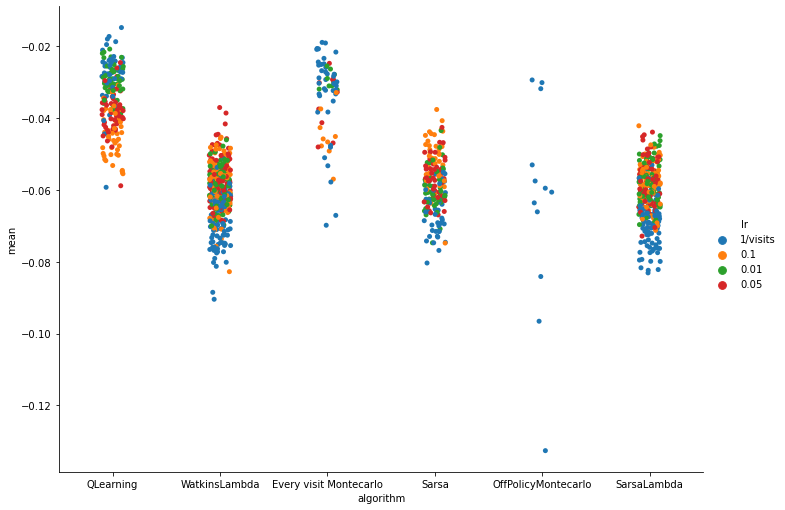

In [15]:
sns.catplot(data=leaderboard[leaderboard['mean'] > -999], x='algorithm', y='mean', hue='lr', height=7,  aspect=7/5)

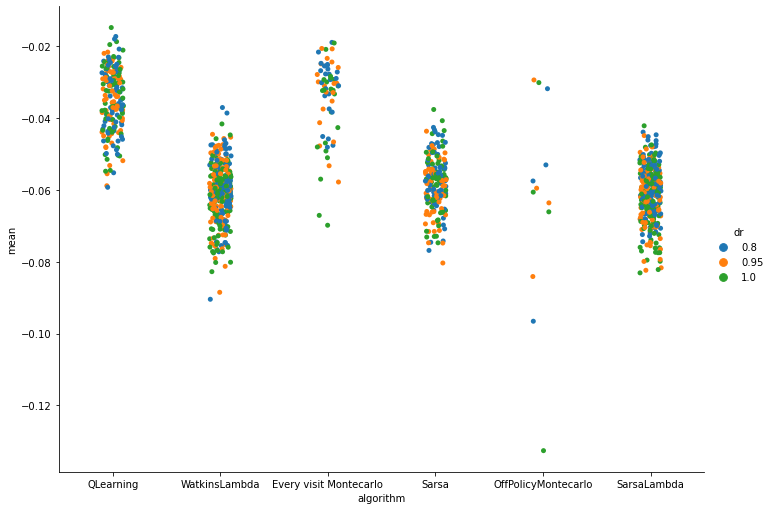

In [16]:
sns.catplot(data=leaderboard[leaderboard['mean'] > -999], x='algorithm', y='mean', hue='dr', height=7,  aspect=7/5)

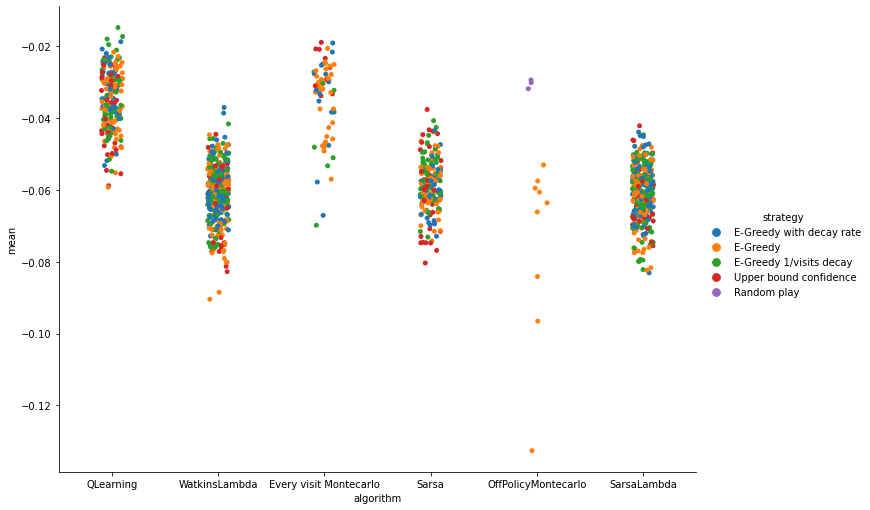

In [19]:
sns.catplot(data=leaderboard[leaderboard['mean'] > -999], x='algorithm', y='mean', hue='strategy', height=7,  aspect=7/5)

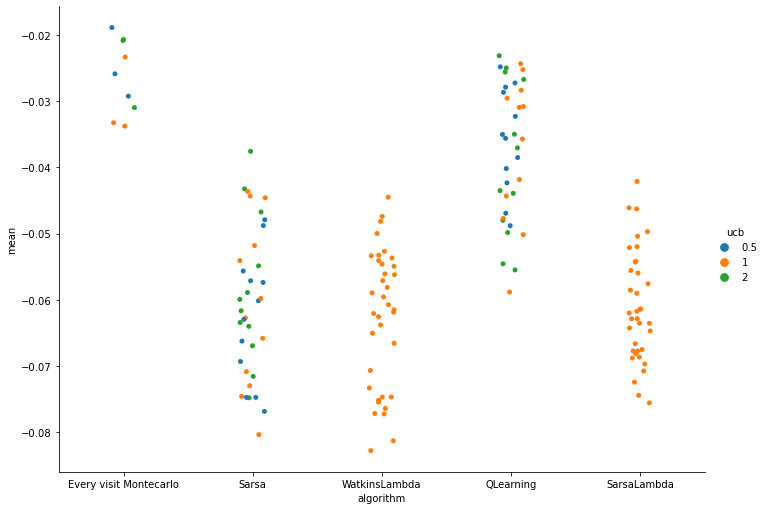

In [21]:
sns.catplot(data=leaderboard[(leaderboard['mean'] > -999) & (leaderboard['ucb'] != 'N/A')],
            x='algorithm', y='mean', hue='ucb', height=7,  aspect=7/5)

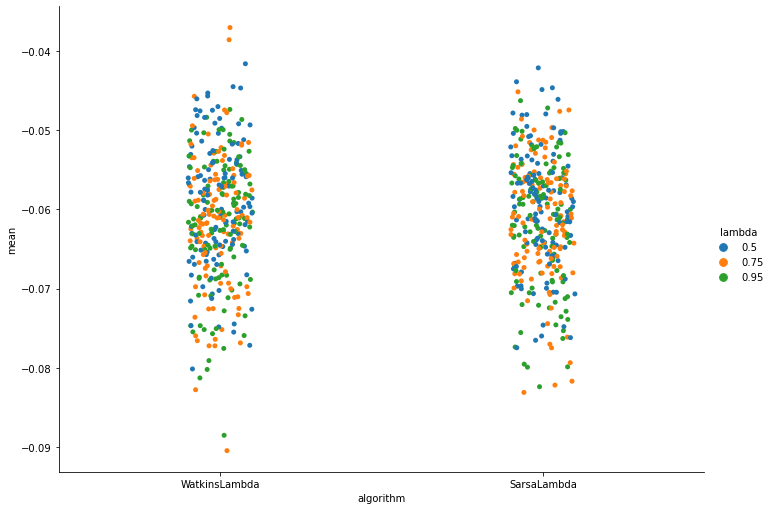

In [23]:
sns.catplot(data=leaderboard[(leaderboard['mean'] > -999) & (leaderboard['lambda'] != 'N/A')],
            x='algorithm', y='mean', hue='lambda', height=7,  aspect=7/5)

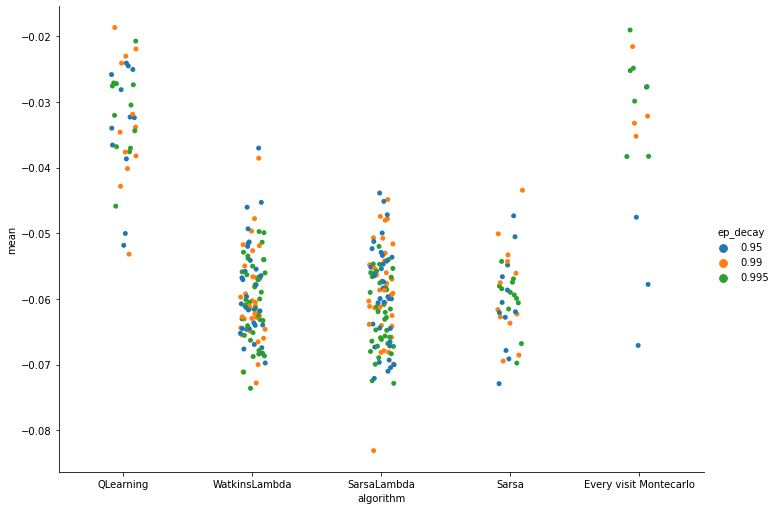

In [24]:
sns.catplot(data=leaderboard[(leaderboard['mean'] > -999) & (leaderboard['ep_decay'] != 'N/A')],
            x='algorithm', y='mean', hue='ep_decay', height=7,  aspect=7/5)

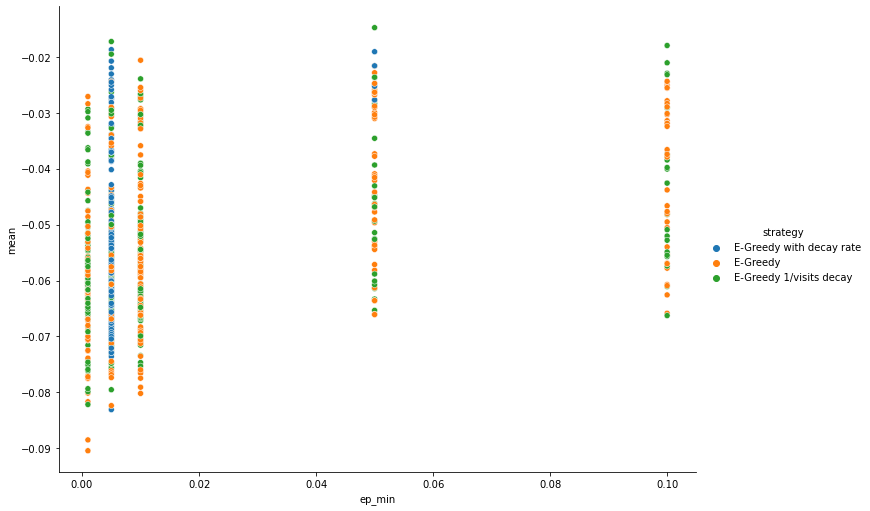

In [31]:
sns.relplot(data=leaderboard[(leaderboard['mean'] > -999) & (leaderboard['ep_min'] != 'N/A')],
           x='ep_min', y='mean', hue='strategy',height=7,  aspect=7/5 )

In [36]:
leaderboard[leaderboard['ep_min']==0.01]

,algorithm,strategy,lr,dr,lambda,traces,ep_min,ep_decay,ucb,Last_episode,results,mean,lower_bound,upper_bound
A_SarsaLambdaVisitsDecay_7fc02c1b14944beca84447028ce265d2,SarsaLambda,E-Greedy 1/visits decay,0.01,0.80,0.75,accumulating,0.01,N/A,N/A,952854,"[-0.04575, -0.0543125, -0.0739375, -0.058375, ...",-0.055500,-0.073423,-0.039047
A_WatkinsFixEpsilon_420a26ceb6364a7da97664518201b11b,WatkinsLambda,E-Greedy,0.05,0.80,0.5,accumulating,0.01,N/A,N/A,952829,"[-0.0624375, -0.0736875, -0.0674375, -0.047812...",-0.064688,-0.076369,-0.047900
A_SarsaLambdaFixEpsilon_8611d90fcc5c448c9389ed690d37a514,SarsaLambda,E-Greedy,0.1,0.95,0.95,accumulating,0.01,N/A,N/A,952622,"[-0.0399375, -0.0600625, -0.0554375, -0.067125...",-0.051125,-0.065889,-0.029780
A_SarsaVisitsDecay_e841658e81834ecbacb87667ea1853a9,Sarsa,E-Greedy 1/visits decay,0.05,0.95,N/A,N/A,0.01,N/A,N/A,952569,"[-0.0441875, -0.06525, -0.071125, -0.07275, -0...",-0.061164,-0.073575,-0.041867
A_WatkinsVisitsDecay_ca68f5ff6d1e43fbbcc061057bfa00b1,WatkinsLambda,E-Greedy 1/visits decay,0.05,1.00,0.5,accumulating,0.01,N/A,N/A,952758,"[-0.0358125, -0.04275, -0.0410625, -0.0373125,...",-0.041609,-0.048125,-0.036075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A_WatkinsFixEpsilon_a63d8f73e39245c3b9b58da766a2ec35,WatkinsLambda,E-Greedy,0.1,0.95,0.95,accumulating,0.01,N/A,N/A,952557,"[-0.0615625, -0.053, -0.037875, -0.054875, -0....",-0.048641,-0.060655,-0.037930
A_WatkinsVisitsDecay_31f6e0f2ab124f80aa358d533793792a,WatkinsLambda,E-Greedy 1/visits decay,0.05,0.95,0.95,accumulating,0.01,N/A,N/A,952596,"[-0.0484375, -0.078125, -0.032875, -0.0600625,...",-0.054445,-0.077009,-0.034877
A_SarsaLambdaVisitsDecay_c722f8c04cf341539acb9415fd3a1a17,SarsaLambda,E-Greedy 1/visits decay,1/visits,0.80,0.75,accumulating,0.01,N/A,N/A,952297,"[-0.06, -0.0679375, -0.0970625, -0.066, -0.068...",-0.069922,-0.093147,-0.057731
A_SarsaLambdaFixEpsilon_32d64c5a190942039b6eb38e9d7f8d13,SarsaLambda,E-Greedy,0.05,1.00,0.5,accumulating,0.01,N/A,N/A,952914,"[-0.0470625, -0.0400625, -0.05125, -0.0405, -0...",-0.050187,-0.064941,-0.040139


### Rubbish:

In [18]:
leaderboard[leaderboard['mean'] == -999]

,algorithm,strategy,lr,dr,lambda,traces,ep_min,ep_decay,ucb,Last_episode,results,mean,lower_bound,upper_bound
A_DecayRate_2923aed748004df4819f142b64433e8e,Every visit Montecarlo,E-Greedy with decay rate,1/visits,1.0,N/A,N/A,0.05,0.995,N/A,952850,-999,-999.0,-999.0,-999.0
A_AlwaysGreedy_3cab8bb2ecd94981bd57c46af642e9f8,Every visit Montecarlo,AlwaysGreedy,1/visits,1.0,N/A,N/A,0.05,0.995,N/A,952505,-999,-999.0,-999.0,-999.0
A_UCB_d9546ca2809d43e4b8b5be4a5d5c33ac,Every visit Montecarlo,Upper bound confidence,1/visits,1.0,N/A,N/A,N/A,N/A,0.5,952697,-999,-999.0,-999.0,-999.0
A_UCB_c53ebd1c23634775a8d0e3a79ccaeac5,Every visit Montecarlo,Upper bound confidence,1/visits,1.0,N/A,N/A,N/A,N/A,2,952762,-999,-999.0,-999.0,-999.0
A_BaseLine_dd0d45691f6543999f41024b78b841b7,MonteCarloPredictor,BaseLine,1/visits,1.0,N/A,N/A,N/A,N/A,N/A,-999,-999,-999.0,-999.0,-999.0
A_FixEpsilon_fd1f72645ff54bda8d657bc204415c66,Every visit Montecarlo,E-Greedy,1/visits,1.0,N/A,N/A,0.01,N/A,N/A,952340,-999,-999.0,-999.0,-999.0
A_FixEpsilon_1e2748d2c9dc4b25940dca10393f47f2,Every visit Montecarlo,E-Greedy,1/visits,1.0,N/A,N/A,0.05,N/A,N/A,952551,-999,-999.0,-999.0,-999.0
A_UCB_253fabab6dc54090adb37a71a16e2b5a,Every visit Montecarlo,Upper bound confidence,1/visits,1.0,N/A,N/A,N/A,N/A,1.5,952575,-999,-999.0,-999.0,-999.0
A_BaseLine_bca2c1123c5c40b09e49ad96e1858a85,Every visit Montecarlo,BaseLine,1/visits,1.0,N/A,N/A,0.05,0.995,N/A,-999,-999,-999.0,-999.0,-999.0
A_BaseLine_2d429c6d05ff462aa3f678747c514b21,MonteCarloPredictor,BaseLine,1/visits,1.0,N/A,N/A,N/A,N/A,N/A,-999,-999,-999.0,-999.0,-999.0
